In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import glob, re
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import csv
import numpy as np 
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.preprocessing import MinMaxScaler
cuda = torch.device('cuda') 

Locate a dataset containing both noisy and noise-free multiexponential decay curves using the provided link: 

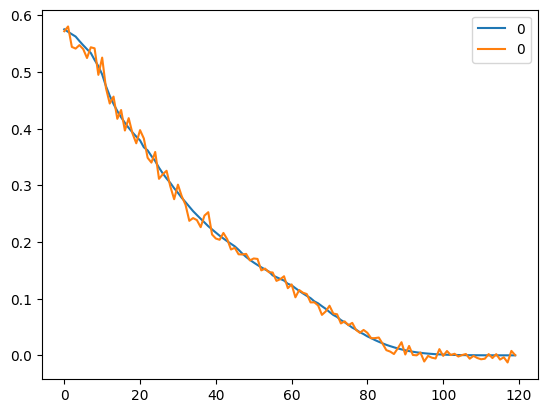

In [2]:
test_csv = pd.read_csv('data/cor_17_5_0.csv', header=None)
test_csv_noised = pd.read_csv('data/cor_17_5_2.csv', header=None)
fig, axs = plt.subplots(1,1)
test_csv.plot.line(ax = axs)
test_csv_noised.plot.line(ax = axs)
plt.show()

In [3]:
pattern = r'cor_\d+_\d+_\d+\.csv'
files = glob.glob(root_dir='data', pathname='*')
r_label = re.compile('cor_\d+_\d+_0+\.csv')
r_noised = re.compile('cor_\d+_\d+_[1-9]+\.csv')
r_label_list = list(filter(r_label.match, files))
r_noised_list = list(filter(r_noised.match, files))
noised_list = []
label_list = []
for label in r_label_list:
    r_label_to_noise = re.compile(label[:-5])
    r_label_noised_list = list(filter(r_label_to_noise.match, r_noised_list))
    for noise in r_label_noised_list:
        noised_list.append(noise)
        label_list.append(label)

Here is creating a dataset with matching labels. 

In [4]:
pd_list_label = []
pd_list_noised = [] 

for i, x in enumerate( tqdm(label_list) ):
    #df = pd.read_csv('data/' + label_list[i], index_col=None, header=0)
    with open('data/' + label_list[i], newline='') as f:
        reader = csv.reader(f, quoting = csv.QUOTE_NONNUMERIC,)
        data = np.array(list(reader)).flatten().tolist()

    pd_list_label.append(data)
    #df = pd.read_csv('data/' + noised_list[i], index_col=None, header=0)
    with open('data/' + noised_list[i], newline='') as f:
        reader = csv.reader(f, quoting = csv.QUOTE_NONNUMERIC,)
        data = np.array(list(reader)).flatten().tolist()
    pd_list_noised.append(data)

  0%|          | 0/4500 [00:00<?, ?it/s]

100%|██████████| 4500/4500 [00:03<00:00, 1297.21it/s]


Creating train/test split by 80% for training 20% for validation

In [5]:
X_train, X_test, y_train, y_test = train_test_split(pd_list_noised, pd_list_label, train_size=0.8, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
y_train = torch.tensor(y_train, dtype=torch.float32).cuda()
X_test = torch.tensor(X_test, dtype=torch.float32).cuda()
y_test = torch.tensor(y_test, dtype=torch.float32).cuda()

Suggest simple and straightforward deep learning algorithm to perform supervised denoising of these curves. Choose a validation strategy for your selected method. Select and justify a metric to evaluate the model's performance. 

And here is the most simple model I can imagine, I`ve also tried running simple VAE for this task, but it has some serious issues like plotting very good-looking curves which were too far from reality.

In [6]:
class BiasLayer(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        bias_value = torch.randn((1))
        self.bias_layer = torch.nn.Parameter(bias_value)
    
    def forward(self, x):
        return x + self.bias_layer
    
class SimpleAndStraightforward(nn.Module):
    def __init__(self, in_ch):
        super(SimpleAndStraightforward, self).__init__()
        self.fc1 = nn.Linear(in_features=in_ch, out_features=int(in_ch*4))
        self.fc2 = nn.Linear(in_features=int(in_ch*4), out_features=int(in_ch*2))
        self.fc3 = nn.Linear(in_features=int(in_ch*2), out_features=in_ch)
        self.fc4 = nn.Linear(in_features=in_ch, out_features=in_ch)
        self.bl = BiasLayer()
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.elu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    


The loss function here is MSE, which granted the best performance, also tried rose, cross-entropy, and loss functions for VAE, also MSE is good for evaluating the performance of the model, as it`s a common metric for regression tasks.

In [7]:
in_ch=120
model = SimpleAndStraightforward(in_ch).cuda()


optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = MultiStepLR(optimizer, milestones=[30000, 70000, 130000, 200000], gamma=0.2)

loss_fn = nn.MSELoss()
n_epochs = 1000  
batch_size = 16  
batch_start = torch.arange(0, len(X_train), batch_size)
loss_test = None

epochs = tqdm(range(n_epochs), desc="Epochs")
batch_start = torch.arange(0, len(X_train), batch_size)
for epoch in epochs:
    for start in batch_start:
        X_batch = X_train[start:start+batch_size]  
        y_batch = y_train[start:start+batch_size]
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    with torch.no_grad():
        model.eval()
        test_pred = model(X_test)
        loss_test = loss_fn(test_pred, y_test)
        loss_test = float(loss_test)
        epochs.set_postfix({'mse_test': loss_test, 'mse':float(loss)})


Epochs: 100%|██████████| 1000/1000 [07:59<00:00,  2.09it/s, mse_test=3.27e-5, mse=3.52e-5]


In [49]:
torch.save(model, 'SimpleAndStraightforward')

In [ ]:
model = torch.load('SimpleAndStraightforward')

here is visualisation of model results 

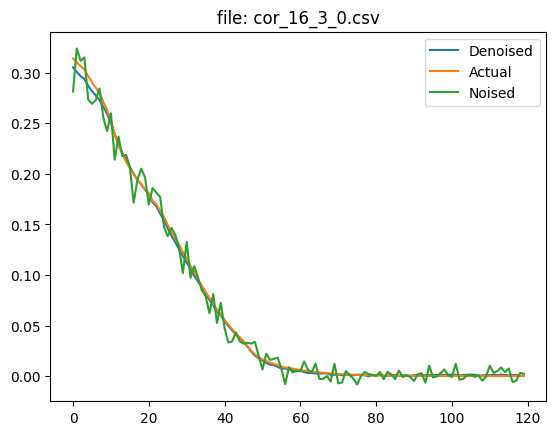

In [8]:
import random
ind = random.randint(0, len(X_test))
test_pred = model(X_test[ind])
y_label= y_test[ind].cpu().detach().numpy()
test_pred_np  = test_pred.cpu().detach().numpy()
test_noised = X_test[ind].cpu().detach().numpy()

df_test_pred = pd.DataFrame(test_pred_np, columns=None).rename(columns={0: 'Denoised'})
df_label = pd.DataFrame(y_label, columns=None).rename(columns={0: 'Actual'})
df_noised= pd.DataFrame(test_noised, columns=None).rename(columns={0: 'Noised'})
fig, axs = plt.subplots(1,1)
df_test_pred.plot.line(ax = axs,)
df_label.plot.line(ax = axs)
df_noised.plot.line(ax = axs)
axs.set_title(f'file: {label_list[ind]}')
plt.show()


Save the denoised curves from the validation dataset as .csv files. Create a train/test demonstration in a Jupyter notebook with basic result visualization.

In [58]:
for i in range(len(X_test)):
    test_pred_np = model(X_test[i]).cpu().detach().numpy()
    np.savetxt(f'denoised_data/{noised_list[i+len(X_train)]}', test_pred_np)


In [259]:

# Normalize data

scaler = MinMaxScaler()
pd_list_noised_t = scaler.fit_transform(pd_list_noised)#.reshape(-1, 1))
pd_list_label_t = scaler.fit_transform(pd_list_label)#.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(pd_list_noised_t, pd_list_label_t, train_size=0.8, shuffle=False)